# --- Zillow project: Home value prediction --- 

# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

Import some functions and preprocessor:

In [2]:
# import functions
def Load_data(dataset, verbose=False):
    '''load one of Zillow dataset'''
    df = pd.read_csv('raw_data/{0}.csv'.format(dataset))
    
    if verbose:
        print('\n{0:*^80}'.format('In {0} dataset'.format(dataset)))
        print('\nit has {0} rows and {1} columns'.format(*df.shape))
        print('\n{0:*^80}'.format(' The columns are'))
        print(df.columns)
        print('\n{0:*^80}'.format(' The top 5 rows are'))
        print(df.head())
    
    return df

def select_per_parcel(df):
    '''drop duplicated to only record for each unique parcel'''
    
    count_per_parcel = df.groupby('parcelid').size()
    more_than_one = df[df.parcelid.isin(count_per_parcel[count_per_parcel > 1].index)]
    only_one = df[df.parcelid.isin(count_per_parcel[count_per_parcel == 1].index)]
    selected_more_than_one = more_than_one.sort_values(by='transactiondate', ascending=False).groupby('parcelid').head(1)
    All_unique_df = pd.concat([only_one, selected_more_than_one])
    
    print(All_unique_df.shape)
    return All_unique_df

def get_data(dataset):
    '''create training dataset 2016 or the test dataset 2017'''
    
    year = {'train': 2016, 'test': 2017}[dataset]
    train = Load_data('train_{0}'.format(year))
    properties = Load_data('properties_{0}'.format(year))
    merge_data = pd.merge(train, properties, how='left', on='parcelid')
    
    if dataset =='train':
        merge_data = select_per_parcel(merge_data)
        
    new_merge = merge_data.pop('logerror')
    return merge_data, new_merge

def mean_absolute_error(new_merge_real, new_merge_predict):
    return np.mean(np.abs(new_merge_real - new_merge_predict))   

In [3]:
class preprocessor:
    
    def __init__(self, cols_to_filter=None,datecols=None):
        
        self.cols_to_filter = cols_to_filter
        self.datecols = datecols
    
    def fit(self, X, y=None):
        """learn any information from the training data we may need to transform the test data"""
        
        self.was_fit = True
        # filter
        X_new = X.drop(self.cols_to_filter, axis=1)
        
        categorical_features = X_new.dtypes[X_new.dtypes == 'object'].index
        self.categorical_features = [x for x in categorical_features if 'date' not in x]
        
        one_hot_encoding = pd.get_dummies(X_new, columns=self.categorical_features, dummy_na=True)
        self.colnames = one_hot_encoding.columns
        del one_hot_encoding
        return self
    
    def transform(self, X, y=None):
        """transform the training or test data learned from fit"""
        if not self.was_fit:
            raise Error('need tto fit preprocessor first')
        
        X_new = X.drop(self.cols_to_filter, axis=1)
        
        # fill null value
        X_new = X_new.fillna(-1)
        
        # encoding variables
        X_new =pd.get_dummies(X_new, columns=self.categorical_features, dummy_na=True)
        newcols = set(self.colnames) - set(X_new.columns)
        for i in newcols:
            X_new[i] = 0
        
        X_new = X_new[self.colnames]
        
        # convert transactiondate to appropriate data type in columns
        if self.datecols:
            for col in self.datecols:
                X_new[col + '_month'] = pd.to_datetime(X_new[col]).apply(lambda x: x.month)
                X_new[col + '_year'] = pd.to_datetime(X_new[col]).apply(lambda x: x.year)
                X_new = X_new.drop(col, axis=1)      
        return X_new
    
    def fit_transform(self, X, y=None):
        '''fit and transform wrapper method for sklearn pipeline purpose use'''
        return self.fit(X).transform(X)

In [4]:
X, y =get_data('train')

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2961: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(90150, 60)


In [5]:
X.head()

,parcelid,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


Now, we can use preprocessor to transform our training data

In [6]:
p = preprocessor(cols_to_filter=['rawcensustractandblock', 'censustractandblock', 'propertyzoningdesc',
                                 'regionidneighborhood', 'regionidzip', 'parcelid'], datecols=['transactiondate'])
X = p.fit_transform(X)
X.head()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,propertycountylandusecode_73,propertycountylandusecode_8800,propertycountylandusecode_96,propertycountylandusecode_nan,fireplaceflag_True,fireplaceflag_nan,taxdelinquencyflag_Y,taxdelinquencyflag_nan,transactiondate_month,transactiondate_year
0,1.0,-1.0,-1.0,2.0,3.0,-1.0,4.0,2.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,1,2016
1,-1.0,-1.0,-1.0,3.5,4.0,-1.0,-1.0,3.5,-1.0,-1.0,...,0,0,0,0,0,0,0,0,1,2016
2,1.0,-1.0,-1.0,3.0,2.0,-1.0,4.0,3.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,1,2016
3,1.0,-1.0,-1.0,2.0,2.0,-1.0,4.0,2.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,1,2016
4,-1.0,-1.0,-1.0,2.5,4.0,-1.0,-1.0,2.5,-1.0,-1.0,...,0,0,0,0,0,0,0,0,1,2016


Here, we have our dataset ready for modeling!

# Model set up

In [7]:
def select_parameters(X, y, max_estimators=1000, max_depth = 3, learning_rate = 0.01):
    X_train, X_tune, y_train, y_tune = train_test_split(X,y,test_size=0.33, random_state=0, shuffle=True)
    
    gbm = GradientBoostingRegressor(n_estimators = max_estimators, learning_rate=learning_rate,
                                   max_depth=max_depth, loss='lad', subsample=0.5)
    gbm.fit(X_train,y_train)
    test_score = np.zeros((max_estimators,), dtype=np.float64)
    
    for i, y_predict in enumerate(gbm.staged_predict(X_tune)):
        test_score[i] = mean_absolute_error(y_tune, y_predict)
        
    print('optimal number of trees: {0}'.format(test_score.argmin()))
    print('best MAE: {0}'.format(test_score.min()))
    print('baseline MAE: {0}'.format(mean_absolute_error(y_tune, y_train.median())))
    pd.Series(test_score).plot(title='learning curve for max_depth = {0}'.format(max_depth))
    plt.show()

Tuning Tree Depth

Since learning_rate and max_estimator are anticorrelated, the higher learning rate the fewer trees needed.

***** training for max depth = 2 *****
optimal number of trees: 828
best MAE: 0.06702976022852218
baseline MAE: 0.06798321344537679


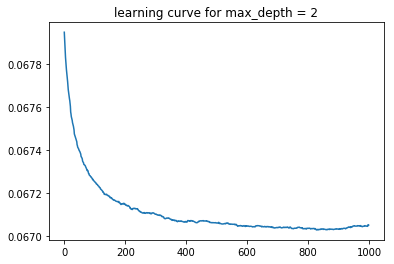

***** training for max depth = 3 *****
optimal number of trees: 326
best MAE: 0.06704172023010302
baseline MAE: 0.06798321344537679


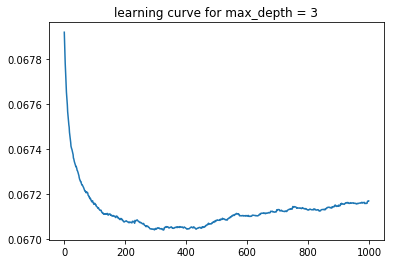

***** training for max depth = 4 *****
optimal number of trees: 198
best MAE: 0.06699329062907161
baseline MAE: 0.06798321344537679


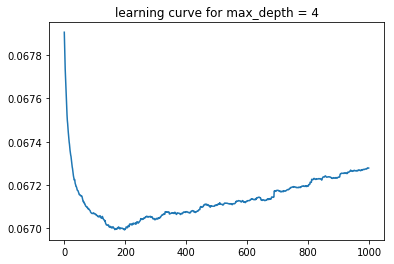

***** training for max depth = 5 *****
optimal number of trees: 122
best MAE: 0.0670939290744163
baseline MAE: 0.06798321344537679


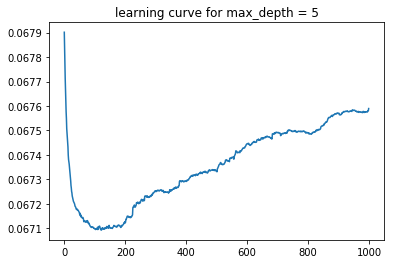

In [8]:
for depth in [2,3,4,5]:
    print('***** training for max depth = {0} *****'.format(depth))
    select_parameters(X,y,max_estimators=1000, max_depth=depth, learning_rate=0.1)

Therefore, we have tested on parameters and finalize as:

       n_estimator = 1000
   
       learning_rate = 0.1
   
       max_depth = 2
   
       loss = 'lad'
   
       subsample = 0.5

# Fit Final Model

In [12]:
# import sklearn.pipeline for Modeling
from sklearn.pipeline import Pipeline

Now we can use our Model to fit our train dataset:

In [10]:
gbm = GradientBoostingRegressor(n_estimators = 1000, learning_rate=0.1,
                                   max_depth=2, loss='lad', subsample=0.5)

p is our preprocessor created before and we will use it directly with gbm regressor model to set up our pipeline:

In [13]:
model = Pipeline([('preprocessor', p), ('regressor', gbm)])

In [14]:
X_train, y_train = get_data('train')

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2961: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(90150, 60)


In [15]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 <__main__.preprocessor object at 0x0000023BDC5F2B00>),
                ('regressor',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='lad', max_depth=2,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=1000,
                                           n_iter_no_change=None,
                              

Predict on Test dataset

In [16]:
X_test, y_test = get_data('test')
y_predict = model.predict(X_test)

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2961: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Model evaluation

In [18]:
mean_absolute_error(y_test, y_predict)

0.06922432799939154

# Plotting the Model result

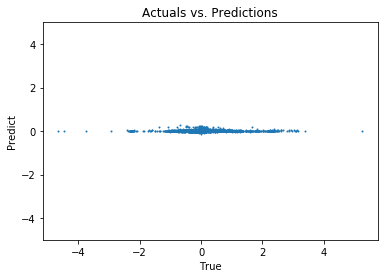

In [19]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_predict, s=1)
ax.set_title('Actuals vs. Predictions')
ax.set_xlabel('True')
ax.set_ylabel('Predict')
ax.set_ylim(-5, 5)
plt.show()

Distribution of Actuals and Predictions

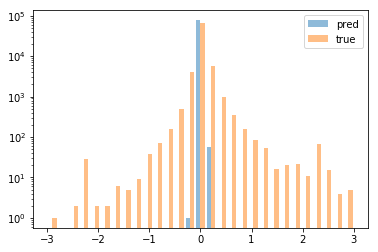

In [21]:
def plot_hists(y_predict, y_true):

    fig, ax = plt.subplots()
    bins = np.linspace(-3, 3, 30)
    ax.hist([y_predict, y_true], label=['pred', 'true'], alpha=0.5, bins=bins, log=True)
    plt.legend(loc='upper right')
    plt.show()
    
plot_hists(y_predict, y_test)

Comparatively, our model predictions have less variance than our true response values

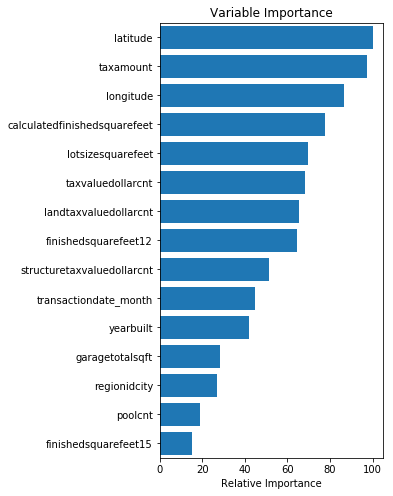

In [27]:
def feat_imp_plot(sk_model, feat_names, N_feature):

    feature_importance = sk_model.feature_importances_
    feature_importance = 100.0 * feature_importance / feature_importance.max()
    sorted_idx = np.argsort(feature_importance)
    total_features = sorted_idx.shape[0]
    pos = np.arange(total_features) + .5

    fig, ax = plt.subplots(figsize=(4,8))
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(fnames[sorted_idx])
    ax.set_ylim(total_features-N_feature, total_features)
    ax.set_xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
fnames = model.steps[0][1].transform(pd.DataFrame(X_test.iloc[0]).T).columns
feat_imp_plot(model.steps[1][1], fnames, 15)